In [0]:
import os
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # used to create png image files

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Pan Galactic Gargle Blaster.csv", sep=';')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## **V.6 Marvin’s rebuttal**

In [0]:
def ft_dot(a, b):
    result = 0
    for i in range(len(a)):
        result += a[i] * b[i]   
    return result

In [0]:
class Adaline(object):
  def __init__(self, lr):
    self.w = None
    self.lr = lr
    self.stats = []

  def _net_input(self, X):
    return ft_dot(self.w, X)

  def _activation_function(self, X):
    net_input = self._net_input(X)
    return 1 / (1 + math.exp(-net_input))

  def predict(self, X):
    return 1 if self._activation_function(X) > 0.5 else 0

  def _eval_epoch(self, X, y):
    num_misclass = 0
    for xi, yi in zip(X, y):
      num_misclass += int(self.predict(xi) != int(yi))
    return num_misclass

  def _train_epoch(self, X, y, epoch, mode, verbose):
    # m length vector of errors of all samples
    # continuous error
    epoch_errors = []

    # zip returns a row of matrix X and an element of vector y
    for xi, yi in zip(X, y):
      yhat = self._activation_function(xi)
      error = yi - yhat
      epoch_errors.append(error)

      # stochastic
      # note, we do not aggregate the error over the entire training sample
      if mode == 'online':
        self.w += self.lr * error * xi

    if mode == 'batch':
      self.w += self.lr * ft_dot(X, epoch_errors)

    num_misclass = self._eval_epoch(X, y)
    if verbose and epoch % 10 == 0:
      print('Epoch {}: {} errors'.format(epoch, num_misclass))
    self.stats.append((epoch, num_misclass, self.w))
    return epoch_errors

  def train(self, X, y, epochs, mode='batch', verbose=False, seed=None):
    if seed:
      random.seed(seed)
    if self.w is None:
      self.w = [0.001 * random.uniform(-1, 1) for i in range(X.shape[1])]
    epoch = 0
    while True:
      epoch_errors = self._train_epoch(X, y, epoch, mode, verbose)
      epoch += 1
      if epochs != 0 and epoch == epochs:
        break
      elif epochs == 0 and epoch_errors == 45: # this will never happen under pure adaline !!!
        break
    return self.stats

  def test_accuracy(self, X, y):
    num_correct = 0
    for xi, yi in zip(X, y):
      num_correct += int(int(yi) == self.predict(xi))
    accuracy = num_correct / len(y)
    print('Test accuracy {0:.3f}%'.format(100*accuracy))
    return accuracy

In [0]:
def plot_errors(ax, stats, epoch):
  epochs = [t[0] for t in stats[:epoch + 1]]
  epoch_errors = [t[1] for t in stats[:epoch + 1]]
  ax.plot(epochs, epoch_errors)
  ax.set_title('Errors as a function of epochs')
  ax.set_xlabel('epoch')
  ax.set_ylabel('classification errors')

def plot_decision_boundary(ax, stats, epoch, X, y, features, good_thresh, bad_thresh):

  x_min = X.loc[:, features[0]].min() - .2
  x_max = X.loc[:, features[0]].max() + .2
  y_min = X.loc[:, features[1]].min() - .2
  y_max = X.loc[:, features[1]].max() + .2

  ax.set_title('Decision Boundary on epoch:  {}'.format(epoch))
  ax.set_xlabel(features[0])
  ax.set_ylabel(features[1])
  ax.set_xlim([x_min, x_max])
  ax.set_ylim([y_min, y_max])

  w0, w1, w2 = stats[epoch][2]
  slope = -w1/w2
  intercept = -w0/w2

  # +2 is used to help shade the entire region
  x_coords = [x_min + (x_max + 2 - x_min) * i/10 for i in range(10)]
  y_coords = [intercept + slope * i for i in x_coords]

  ax.plot(x_coords, y_coords, 'b--', label='Decision Boundary')
  ax.fill_between(x_coords, y_coords, y_min - 2, color='#99ff99', alpha=.5)
  ax.fill_between(x_coords, y_coords, y_max + 2, color='#ff9999', alpha=.5)

  good_wines = X[y['y'] == True]
  ax.scatter(good_wines[features[0]], good_wines[features[1]], c=['g'], edgecolor='black', linewidth=2, alpha=0.65, label='good wines %d'%(good_thresh))
  bad_wines = X[y['y'] == False]
  ax.scatter(bad_wines[features[0]], bad_wines[features[1]], c=['r'], edgecolor='black', linewidth=2, alpha=0.65, label='bad wines %d'%(bad_thresh))
  ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

def plot_stats(stats, X, y, features, good_thresh, bad_thresh, epoch=-1):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
  if epoch > len(stats) - 1:
    raise ValueError('Number of epochs should be less than {}'.format(len(stats)))
  if epoch == -1:
    epoch = len(stats) - 1
  plot_errors(ax[0], stats, epoch)
  plot_decision_boundary(ax[1], stats, epoch, X, y, features, good_thresh, bad_thresh)
  return fig

In [0]:
def feature_scaling(series):
  return (series - series.mean()) / (series.max() - series.min())

In [0]:
def k_fold_split(data, k, shuffle=True):
  folds = []
  if shuffle:
    data = data.sample(frac=1).reset_index(drop=True)
    # sampling 100% here

  for i in range(k):
    size = data.shape[0] // k + 1 if i < data.shape[0] % k else data.shape[0] // k
    test_data = data.iloc[i * size: (i + 1) * size, :]
    train_data = data.iloc[data.index.difference(test_data.index), :]
    folds.append((train_data, test_data))
  return folds

In [0]:
def k_fold_adaline(folds, features, lr=0.05, epochs=500, mode='batch', verbose=False):
  sum_accuracy = 0

  for i, fold in enumerate(folds):
    X_train = fold[0][features]
    y_train = fold[0]['y']
    ad = Adaline(lr=lr)
    train_stats = ad.train(X_train.values, y_train.values, epochs, mode, verbose)
    X_test = fold[1][features]
    y_test = fold[1]['y']
    accuracy = ad.test_accuracy(X_test.values, y_test.values)
    sum_accuracy += accuracy

  print('K Fold: Mean accuracy {0:.3f}'.format(sum_accuracy / len(folds)))

In [0]:
def train_test_split(data, test_size=0.3):
  train_set = data.sample(frac=(1 - test_size))
  test_set = data.drop(train_set.index)
  print('Train set {}'.format(train_set.shape))
  print('Test set {}'.format(test_set.shape))
  return (train_set, test_set)

a) While not a wine... find a way to successfully classify the Pan-Galactic Gargle Blaster dataset. Show that your perceptron or ADALINE successfully classifies the Pan- Galactic Gargle Blaster data set by plotting the decision boundary and also show ‘good’ and ‘bad’ Gargle Blaster data points.

In [17]:
df

,wonderflonium,fallian marsh gas,quality
0,4.151636,5.350607,2
1,3.403125,4.787343,2
2,5.036224,4.609847,2
3,4.483534,4.332340,9
4,4.215979,5.220295,2
...,...,...,...
995,4.427725,4.337821,6
996,3.804685,3.697738,3
997,4.572932,3.253231,2
998,4.099439,3.240547,1


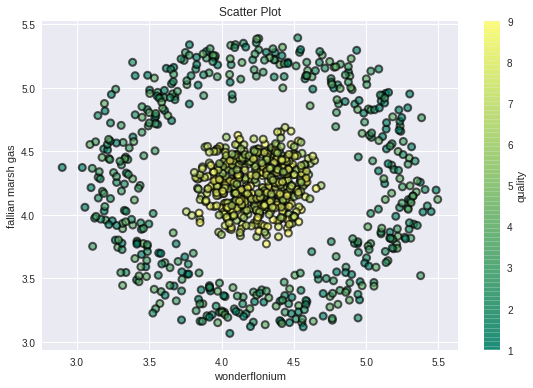

In [10]:
# SCATTER PLOT

plt.style.use('seaborn')
plt.scatter(df['wonderflonium'], df['fallian marsh gas'], c=df['quality'], cmap='summer', edgecolor='black', linewidth=2, alpha=0.65)
# s=100 makes the dot larger
# c='green', for color green
# marker='X', to make dot into X
# edgecolor, edge color of the dots
# linewidth, how thick are the edges circles around the dots
# alpha, to soften the color of the green dots
# c=colors gives you different color for the dots
# cmap='Greens', gives you different shades of green instead of grey
cbar = plt.colorbar()
cbar.set_label('quality')
plt.title('Scatter Plot')
plt.xlabel('wonderflonium')
plt.ylabel('fallian marsh gas')
plt.tight_layout()

In [0]:
good_threshold = 9
bad_threshold = 1
sdf = df[(df['quality'] >= good_threshold) | (df['quality'] <= bad_threshold)]
sdf = sdf.assign(y = pd.Series(sdf['quality'] >= good_threshold))
sdf = sdf.reset_index(drop=True)


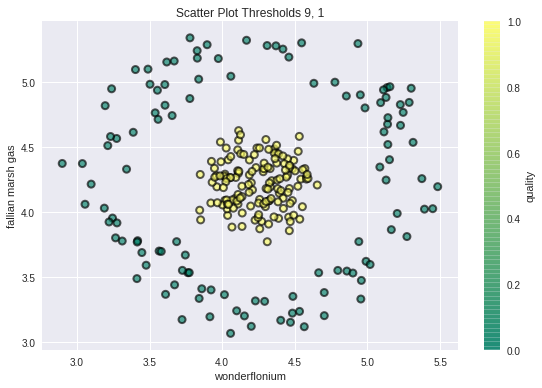

In [15]:
# SCATTER PLOT

plt.style.use('seaborn')
plt.scatter(sdf['wonderflonium'], sdf['fallian marsh gas'], c=sdf['y'], cmap='summer', edgecolor='black', linewidth=2, alpha=0.65)
# s=100 makes the dot larger
# c='green', for color green
# marker='X', to make dot into X
# edgecolor, edge color of the dots
# linewidth, how thick are the edges circles around the dots
# alpha, to soften the color of the green dots
# c=colors gives you different color for the dots
# cmap='Greens', gives you different shades of green instead of grey
cbar = plt.colorbar()
cbar.set_label('quality')
plt.title('Scatter Plot Thresholds {}, {}'.format(good_threshold, bad_threshold))
plt.xlabel('wonderflonium')
plt.ylabel('fallian marsh gas')
plt.tight_layout()

In [0]:
# feature scaling, applied only to X inputs, not to y targets !
#sdf['wonderflonium'] = feature_scaling(sdf['wonderflonium'])
#sdf['fallian marsh gas'] = feature_scaling(sdf['fallian marsh gas'])

In [0]:
X = sdf.loc[:, ['wonderflonium', 'fallian marsh gas']]
X = X.reset_index(drop=True)
X.insert(0, 'x0', 1)
y = sdf.loc[:, ['y']]
y = y.reset_index(drop=True)

In [0]:
ad = Adaline(lr=0.05)
epochs = 300
mode = 'batch'
stats_ad = ad.train(X.values, y.values, epochs=epochs, mode=mode, verbose=False)

Good Threshold 9 Bad Threshold 1


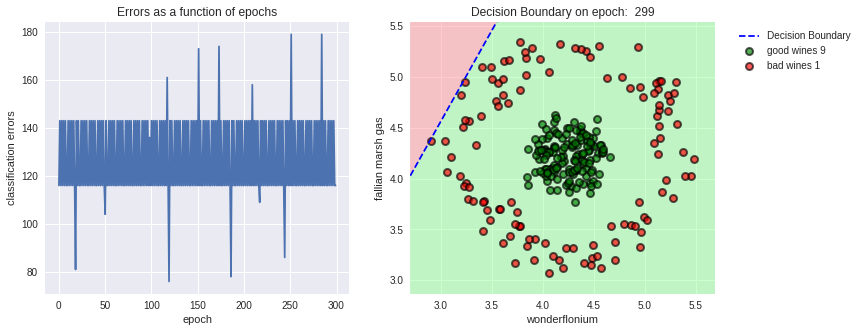

In [21]:
print('Good Threshold {} Bad Threshold {}'.format(good_threshold, bad_threshold))
epoch = epochs - 1
features = ['wonderflonium', 'fallian marsh gas']
fig = plot_stats(stats_ad, X, y, features, good_threshold, bad_threshold, epoch=epoch)
# epoch = -1 means display the decision boundary based upon the last entry.


Given that both Perceptron and Adaline are linear models, they cannot be trained to separate the data, in its raw form.  We can easily see that no hyperplane can separate the good and bad points, given the data, as shown in the scatter plot.

If our model was a multilayer perceptron, then we would be able to classify such data.

Alternatively, given our limited models, we can transform our raw data in the x-y coordinate system, into polar coordinates and then linearly separate the data in the new space.

In [22]:
X

,x0,wonderflonium,fallian marsh gas
0,1,4.483534,4.332340
1,1,4.358374,4.484558
2,1,3.672214,3.440111
3,1,4.940593,3.772474
4,1,3.502908,4.981997
...,...,...,...
254,1,3.725823,3.551397
255,1,5.245842,4.765781
256,1,4.459043,5.190688
257,1,4.008164,4.187378


In [0]:
x1 = sdf.loc[:, 'wonderflonium']
x2 = sdf.loc[:, 'fallian marsh gas']

# feature scaling
# scaling is need to attain linearly separable data in polar coordinates !!!
x1 = feature_scaling(x1)
x2 = feature_scaling(x2)
sdf = sdf.assign(x1=pd.Series(x1))
sdf = sdf.assign(x2=pd.Series(x2))


In [24]:
# Polar Coordinates: compute its corresponding r and phi
sdf = sdf.assign(r=pd.Series(x1 * x1 + x2 * x2).pow(1./2))
#sdf = sdf.assign(phi=pd.Series([math.atan2(x, y) for (x, y) in zip(x1, x2)]))
sdf = sdf.assign(phi=pd.Series([math.atan(y/x) for (x, y) in zip(x1, x2)]))
sdf

,wonderflonium,fallian marsh gas,quality,y,x1,x2,r,phi
0,4.483534,4.332340,9,True,0.095948,0.048394,0.107462,0.467143
1,4.358374,4.484558,9,True,0.047527,0.115402,0.124806,1.180129
2,3.672214,3.440111,1,False,-0.217935,-0.344373,0.407540,1.006575
3,4.940593,3.772474,1,False,0.272776,-0.198064,0.337099,-0.628033
4,3.502908,4.981997,1,False,-0.283436,0.334379,0.438344,-0.867669
...,...,...,...,...,...,...,...,...
254,3.725823,3.551397,1,False,-0.197195,-0.295384,0.355159,0.982156
255,5.245842,4.765781,1,False,0.390871,0.239199,0.458253,0.549171
256,4.459043,5.190688,1,False,0.086474,0.426247,0.434930,1.370641
257,4.008164,4.187378,9,True,-0.087963,-0.015420,0.089304,0.173533


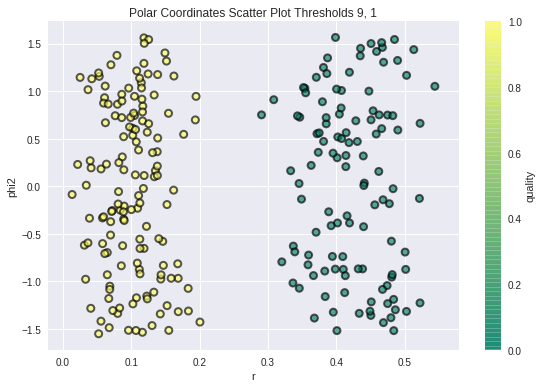

In [25]:
# SCATTER PLOT

plt.style.use('seaborn')
plt.scatter(sdf['r'], sdf['phi'], c=sdf['y'], cmap='summer', edgecolor='black', linewidth=2, alpha=0.65)
# s=100 makes the dot larger
# c='green', for color green
# marker='X', to make dot into X
# edgecolor, edge color of the dots
# linewidth, how thick are the edges circles around the dots
# alpha, to soften the color of the green dots
# c=colors gives you different color for the dots
# cmap='Greens', gives you different shades of green instead of grey
cbar = plt.colorbar()
cbar.set_label('quality')
plt.title('Polar Coordinates Scatter Plot Thresholds {}, {}'.format(good_threshold, bad_threshold))
plt.xlabel('r')
plt.ylabel('phi2')
plt.tight_layout()

In [26]:
train_set, test_set = train_test_split(sdf, test_size=0.3)

Train set (181, 8)
Test set (78, 8)


In [0]:
X_train = train_set.loc[:, ['r', 'phi']]
X_train.insert(0, 'x0', 1)
X_train = X_train.reset_index(drop=True)
y_train = train_set.loc[:, ['y']]
y_train = y_train.reset_index(drop=True)

X_test = test_set.loc[:, ['r', 'phi']]
X_test.insert(0, 'x0', 1)
X_test = X_test.reset_index(drop=True)
y_test = test_set.loc[:, ['y']]
y_test = y_test.reset_index(drop=True)

Good Threshold 9 Bad Threshold 1
Test accuracy 100.000%


1.0

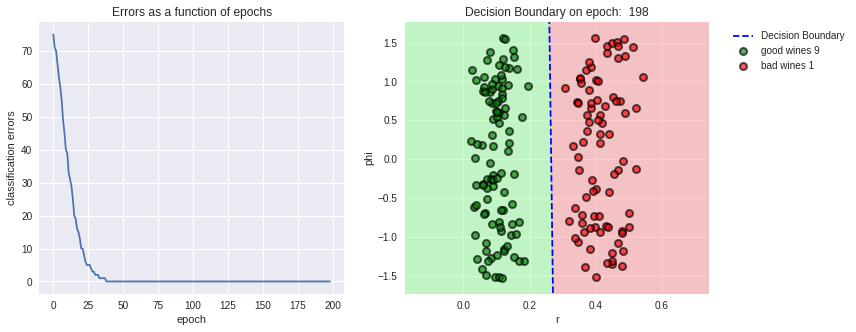

In [28]:
ad = Adaline(lr=0.005)
epochs = 200
mode = 'batch'
stats_ad = ad.train(X_train.values, y_train.values, epochs=epochs, mode=mode, verbose=False)

print('Good Threshold {} Bad Threshold {}'.format(good_threshold, bad_threshold))
epoch = epochs - 2
features = ['r', 'phi']
fig = plot_stats(stats_ad, X_train, y_train, features, good_threshold, bad_threshold, epoch=epoch)

ad.test_accuracy(X_test.values, y_test.values)

NOTE, FEATURE SCALING IS NEEDED TO INSURE LINEAR SEPARABILITY OF THE DATA, ALONG WITH POLAR TRANSFORMATION.